# Tensorflow with MNIST data

## Check if GPU is used

In [4]:
import tensorflow as tf

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))
    
print("GPU is being used!")

[[22. 28.]
 [49. 64.]]
GPU is being used!


## Load Data

In [5]:
import tensorflow as tf
# from tqdm import tqdm
from tensorflow.contrib.layers import flatten

import math
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from helper.helper_functions import *
from helper.generate_data_mnist import *

from sklearn.svm import LinearSVC
from functions.training_functions_local_svd import *
from functions.test_functions_local_svd import *

np.random.seed(1337)  # for reproducibility

SIZE = 1000
# Generate the data
X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = mnist_generate_data(reduced=False, train_size = SIZE, padding=False)


Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
y train one hot encoding: (55000, 10)
y test one hot encoding: (10000, 10)

Training Set:   (55000, 28, 28, 1)
Validation Set: (5000, 28, 28, 1)
Test Set:       (10000, 28, 28, 1)
Done!


In [6]:
y_train = y_train.ravel()
y_test = y_test.ravel()
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

print(y_train[:10])

[7 3 4 6 1 8 1 0 9 8]


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

## Visualize Data

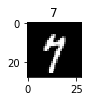

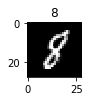

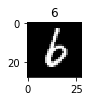

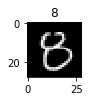

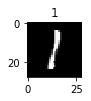

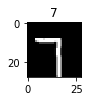

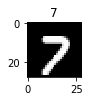

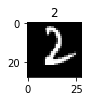

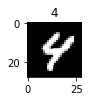

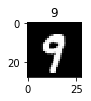

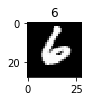

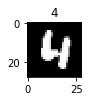

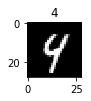

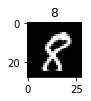

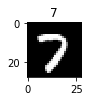

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(15):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()

    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")
    plt.title(y_train[index])
    plt.show()

## Preprocess Data

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Implement LeNet Pipeline

### Input
32x32x1 image as input.

### Architecture
**Layer 1: Convolutional.** The output shape is 28x28x6.

**Activation.** ReLU.

**Pooling.** The output shape is 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** ReLU.

**Pooling.** The output shape is 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3: Fully Connected.** 120 outputs.

**Activation.** ReLU.

**Layer 4: Fully Connected.** This is 84 outputs.

**Activation.** ReLU.

**Layer 5: Fully Connected (Logits).** 10 outputs.

### Output
Return the result of the 2nd fully connected layer.


```python
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
```

In [9]:
def pipeline(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
        
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 14x14x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 14x14x64. Output = 7x7x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 7x7x64. Output = 7*7*64.
    fc0   = flatten(conv2)
    
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(7*7*64, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
            
    # Dropout
    fc1 = tf.nn.dropout(fc1, 0.6)

    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 10), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(10))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    logits    = tf.nn.relu(fc2)
    
    return [logits,fc0]

## Features and Labels

In [10]:
x = tf.placeholder(tf.float32, (None, 28, 28, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

## Training Pipeline - cross_entropy is modified

In [11]:
rate = 0.001

logits, fc0_ = pipeline(x)
# print(fc0.eval())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    Amat = np.zeros((len(y_train),7*7*64))
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    start_ind = 0
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run([accuracy_operation,fc0_], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy[0] * len(batch_x))
        
        Amat[start_ind:start_ind+accuracy[1].shape[0],:] = accuracy[1]
        start_ind += accuracy[1].shape[0]
        
    return total_accuracy / num_examples, Amat

## Train the Model

In [13]:
BATCH_SIZE = 128

accuracy_tf  = []
accuracy_svc_linear = []
accuracy_svc_rbf = []

# epochs_range = range(1,50,2)
epochs_range = [50]

for EPOCHS in epochs_range:
    print("EPOCHS =",EPOCHS)
    
    Amat = np.zeros((len(y_train),7*7*64))

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")

        for i in range(EPOCHS):

            start_ind = 0

            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                output = sess.run([training_operation,fc0_], feed_dict={x: batch_x, y: batch_y})

                Amat[start_ind:start_ind+output[1].shape[0],:] = output[1]
                start_ind += output[1].shape[0]

        test_accuracy, Amat_test = evaluate(X_test, y_test)
        print("\nTest Accuracy = {:.3f}".format(test_accuracy))

#     Amat = Amat.T
#     Amat_test = Amat_test.T    

#     # With linear kernel
#     svc = train_svm(Amat, y_train, kernel='linear')

#     prediction = predict_svm(Amat_test, svc, y_test, u=[], s=[])

#     correct = 0.
#     for i in range(len(prediction)):
#         if prediction[i] == y_test[i]:
#             correct+=1.
        
#     svc_linear_accuracy = float(correct)/len(prediction)

#     print('====================================')
#     print('Accuracy by SVC (linear):', svc_linear_accuracy)
#     print('====================================')
    
#     # With rbf kernel
#     svc = train_svm(Amat, y_train, kernel='rbf')

#     prediction = predict_svm(Amat_test, svc, y_test, u=[], s=[])

#     correct = 0.
#     for i in range(len(prediction)):
#         if prediction[i] == y_test[i]:
#             correct+=1.

#     svc_rbf_accuracy = float(correct)/len(prediction)
    
#     print('====================================')
#     print('Accuracy by SVC (linear):', svc_rbf_accuracy)
#     print('====================================')    
    
    accuracy_tf.append(test_accuracy)
#     accuracy_svc_linear.append(svc_linear_accuracy)
#     accuracy_svc_rbf.append(svc_rbf_accuracy)

EPOCHS = 50
Training...

Test Accuracy = 0.959


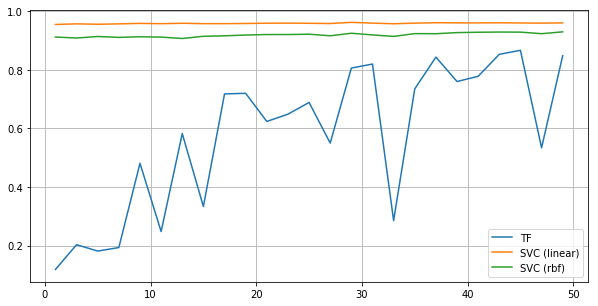

In [10]:
plt.figure(figsize=(10,5))
plt.plot(epochs_range, accuracy_tf, label="TF")
plt.plot(epochs_range, accuracy_svc_linear, label="SVC (linear)")
plt.plot(epochs_range, accuracy_svc_rbf, label="SVC (rbf)")
plt.legend()
plt.grid()
plt.savefig("TF (standard) vs. SVC (linear) vs. SVC (rbf).png")
plt.show()
np.savez("tf-standard-model-svc-two-kernels.npz", accuracy_tf=accuracy_tf,\
        accuracy_svc_linear=accuracy_svc_linear, \
        accuracy_svc_rbf=accuracy_svc_rbf)